This is a test file for the VQC implementation of a HEP classification problem.

@author: Eric Drechsler (dr.eric.drechsler@gmail.com)

Copied from qiskit-community-tutorials

In [1]:
import time
time0=time.time()
import pandas
import pickle

from qiskit import BasicAer
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput
import numpy as np
from plotter import plotTruth,plotVars
from argparse import ArgumentParser

Argparser needs a couple of hacks in jupyter NB. Parse with empty string (''). Check logic of store-true flags.|

In [13]:
argParser = ArgumentParser(add_help=False)
argParser.add_argument( '-t', '--steerTestRun', action="store_true")
argParser.add_argument( '-od', '--steerOutDir', help='Output Directory', default="./")
argParser.add_argument( '-nevt', '--numberEvents', help='Number of events', default=1000)
argParser.add_argument( '-sh',   '--numberShots', help='Number of shots', default=1024)
argParser.add_argument( '-mt',   '--maxTrials', help='Max trials SPSA', default=20)
argParser.add_argument( '-ss',   '--saveSteps', help='SPSA save steps', default=5)
argParser.add_argument( '-vfd',  '--varFormDepth', help='variational form depth', default=2)
argParser.add_argument( '-fmd',  '--featMapDepth', help='Feature Map depth', default=1)
args = argParser.parse_args('')

Read and prepare input data from pickled pandas dataframe.

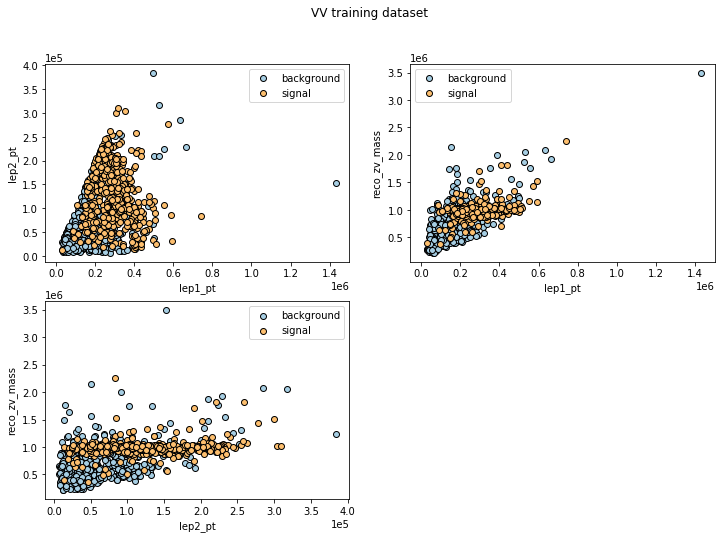

In [15]:
in_df = pandas.read_pickle("MixData_PD.pkl")

nevt = int(args.numberEvents)
var1 = 'lep1_pt'
var2 = 'lep2_pt'
var3 = 'reco_zv_mass'
nvars = 3

y_train_label=in_df['isSignal'].values[:nevt] #[0 1 0 ...]
y_test_label=in_df['isSignal'].values[nevt:2*nevt] #same
x_train=in_df.loc[:nevt-1,[var1, var2, var3]].values #[[var1 var2 var3], [var1 var2 var3],...]
x_test=in_df.loc[nevt:2*nevt-1,[var1, var2, var3]].values
y_train=np.eye(2)[y_train_label]
y_test=np.eye(2)[y_test_label]

trainDict={"signal": [], "background": []}
testDict ={"signal": [], "background": []}


label_names = ['background','signal']
#plotVars(x_train, in_df, label_names)
plotTruth(x_train,in_df,label_names)

In [3]:
#TODO better way of dealing with this?
for i in range(0,nevt):
    if (y_train_label[i]==1):
        trainDict["signal"].append(x_train[i].tolist())
    else:
         trainDict["background"].append(x_train[i].tolist())
trainDict={"signal": np.array(trainDict["signal"]), "background":  np.array(trainDict["background"])}
            
for i in range(0,nevt):
    if (y_test_label[i]==1):
        testDict["signal"].append(x_test[i].tolist())
    else:
         testDict["background"].append(x_test[i].tolist())
testDict={"signal": np.array(testDict["signal"]), "background":  np.array(testDict["background"])}

Declarative definition of algorithm. Can be changed to import objects directly.

In [4]:
params = {
    'problem': {'name': 'classification', 'random_seed': 420 },
    'algorithm': {'name': 'VQC', 'override_SPSA_params': True},
    'backend': {'shots': int(args.numberShots)},
    'optimizer': {'name': 'SPSA', 'max_trials': int(args.maxTrials), 'save_steps': int(args.saveSteps)},
    'variational_form': {'name': 'RYRZ', 'depth': int(args.varFormDepth)},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': int(args.featMapDepth)},
}

Set input and get backend. Run algorithm.

In [9]:
classification_input = ClassificationInput(trainDict, testDict, x_test)
backend = BasicAer.get_backend('qasm_simulator')
result=None
if args.steerTestRun:
    result = run_algorithm(params, classification_input, backend=backend)
    print("testing success ratio: ", result['testing_accuracy'])
    print("predicted classes:", result['predicted_classes'])

Store result.

In [14]:
#time or tag setting in name
outtag="_".join([str(vars(args)[i]) if not "steer" in str(i) else "" for i in vars(args)])
outtag+="_%s"%(int(time.time()))
pklFile=open("{0}/qicl_test_{1}.pkl".format(args.steerOutDir,outtag),'wb')
pickle.dump( result , pklFile)
pickle.dump( vars(args) , pklFile)

m, s = divmod(time.time()-time0, 60)
h, m = divmod(m, 60)
print("Execution time: %d:%02d:%02d" % (h,m,s))
print("Success!")

Execution time: 0:10:24
Success!
